In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm

In [2]:
class Arm:
    def __init__(self, unique_id, true_mean, true_std):
        self.unique_id = unique_id
        self.true_mean = true_mean
        self.true_std = true_std
    
    def pull(self):
        return np.random.normal(self.true_mean, self.true_std)

In [3]:
class MultiArmedBandit:
    def __init__(self, arms, strategy='epsilon_greedy', epsilon=0.1):
        self.arms = arms
        self.n_arms = len(arms)
        self.strategy = strategy
        self.epsilon = epsilon
    
    def select_arm_random(self):
        return np.random.choice(self.arms)
    
    def select_arm_greedy(self, values):
        return max(self.arms, key=lambda arm: values[arm.unique_id])
    
    def select_arm_epsilon_greedy(self, values):
        if np.random.random() < self.epsilon:
            return self.select_arm_random()
        else:
            return self.select_arm_greedy(values)
    
    def select_arm(self, values):
        if self.strategy == 'random':
            return self.select_arm_random()
        elif self.strategy == 'greedy':
            return self.select_arm_greedy(values)
        elif self.strategy == 'epsilon_greedy':
            return self.select_arm_epsilon_greedy(values)
        else:
            raise ValueError(f"Unknown strategy: {self.strategy}")

In [4]:
def run_simulation(mab, n_steps):
    values = {arm.unique_id: 0 for arm in mab.arms}
    counts = {arm.unique_id: 0 for arm in mab.arms}
    cumulative_reward = 0
    rewards = []

    for _ in range(n_steps):
        chosen_arm = mab.select_arm(values)
        reward = chosen_arm.pull()

        # Update tracking
        arm_id = chosen_arm.unique_id
        counts[arm_id] += 1
        n = counts[arm_id]
        value = values[arm_id]
        new_value = ((n - 1) / n) * value + (1 / n) * reward
        values[arm_id] = new_value
        cumulative_reward += reward
        rewards.append(reward)

    return rewards, values, counts, cumulative_reward

In [5]:
def visualize_true_distributions(arms):
    plt.figure(figsize=(12, 6))
    x = np.linspace(-5, 5, 1000)
    
    colors = plt.cm.rainbow(np.linspace(0, 1, len(arms)))
    
    for i, (arm, color) in enumerate(zip(arms, colors)):
        y = norm.pdf(x, arm.true_mean, arm.true_std)
        plt.plot(x, y, label=f'Arm {i} (μ={arm.true_mean:.2f}, σ={arm.true_std:.2f})', color=color)
        
        # Add vertical line at the mean
        plt.axvline(x=arm.true_mean, color=color, linestyle='--', alpha=0.7)
    
    plt.title("True Reward Distributions for Each Arm")
    plt.xlabel("Reward")
    plt.ylabel("Probability Density")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [6]:
# Create arms with different true means and standard deviations
arms = [
    Arm(0, 0.0, 1),
    Arm(1, 0.5, 1),
    Arm(2, 1.0, 1),
    Arm(3, 1.5, 1),
    Arm(4, 2.0, 1)
]

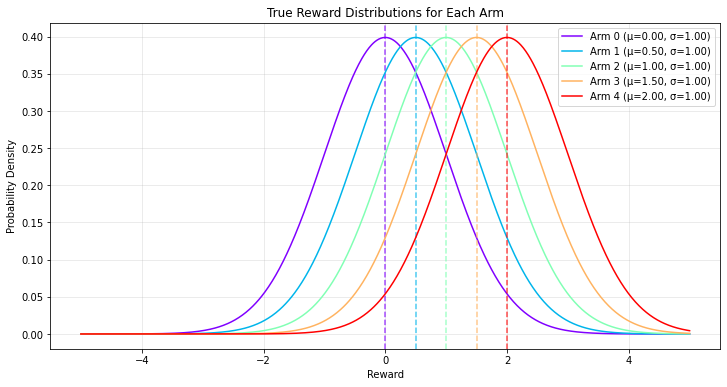

In [7]:
# Visualize the true reward distributions
visualize_true_distributions(arms)

In [8]:
# Simulation parameters
num_steps = 1000
strategies = ['random', 'greedy', 'epsilon_greedy']

In [9]:
# Run simulations for each strategy
results = {}
final_values = {}
final_counts = {}
cumulative_rewards = {}

for strategy in strategies:
    mab = MultiArmedBandit(arms, strategy=strategy)
    rewards, values, counts, cumulative_reward = run_simulation(mab, num_steps)
    results[strategy] = rewards
    final_values[strategy] = values
    final_counts[strategy] = counts
    cumulative_rewards[strategy] = cumulative_reward

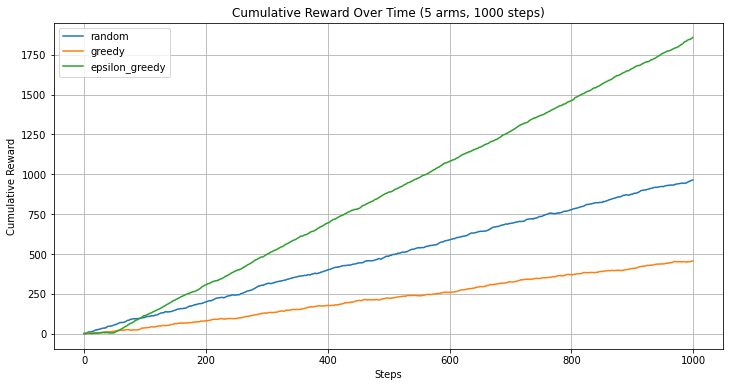

In [10]:
# Plot cumulative reward over time
plt.figure(figsize=(12, 6))
for strategy, rewards in results.items():
    plt.plot(np.cumsum(rewards), label=strategy)

plt.title(f"Cumulative Reward Over Time ({len(arms)} arms, {num_steps} steps)")
plt.xlabel("Steps")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.grid(True)
plt.show()

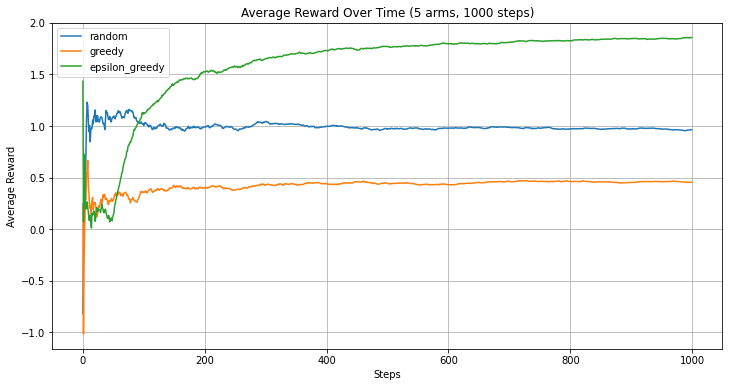

In [11]:
# Plot average reward over time
plt.figure(figsize=(12, 6))
for strategy, rewards in results.items():
    average_reward = np.cumsum(rewards) / (np.arange(len(rewards)) + 1)
    plt.plot(average_reward, label=strategy)

plt.title(f"Average Reward Over Time ({len(arms)} arms, {num_steps} steps)")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend()
plt.grid(True)
plt.show()

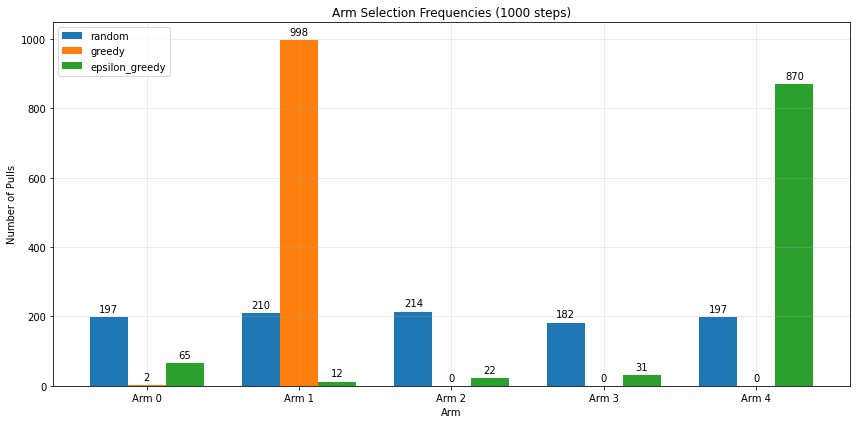

In [12]:
# Plot arm selection frequencies
plt.figure(figsize=(12, 6))
x = np.arange(len(arms))
bar_width = 0.25
multiplier = 0

for strategy, counts in final_counts.items():
    arm_pulls = list(counts.values())
    offset = bar_width * multiplier
    rects = plt.bar(x + offset, arm_pulls, bar_width, label=strategy)
    plt.bar_label(rects, padding=3)
    multiplier += 1

plt.title(f"Arm Selection Frequencies ({num_steps} steps)")
plt.xlabel("Arm")
plt.ylabel("Number of Pulls")
plt.xticks(x + bar_width, [f"Arm {i}" for i in range(len(arms))])
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [13]:
# Print final arm values and counts for each strategy
for strategy in strategies:
    print(f"\nFinal arm values and counts for {strategy} strategy:")
    for arm in arms:
        print(f"Arm {arm.unique_id}: True mean = {arm.true_mean:.2f}, "
              f"Estimated value = {final_values[strategy][arm.unique_id]:.2f}, "
              f"Pull count = {final_counts[strategy][arm.unique_id]}")
    print(f"Total reward: {cumulative_rewards[strategy]:.2f}")


Final arm values and counts for random strategy:
Arm 0: True mean = 0.00, Estimated value = 0.00, Pull count = 197
Arm 1: True mean = 0.50, Estimated value = 0.52, Pull count = 210
Arm 2: True mean = 1.00, Estimated value = 0.97, Pull count = 214
Arm 3: True mean = 1.50, Estimated value = 1.43, Pull count = 182
Arm 4: True mean = 2.00, Estimated value = 1.96, Pull count = 197
Total reward: 964.05

Final arm values and counts for greedy strategy:
Arm 0: True mean = 0.00, Estimated value = -1.02, Pull count = 2
Arm 1: True mean = 0.50, Estimated value = 0.46, Pull count = 998
Arm 2: True mean = 1.00, Estimated value = 0.00, Pull count = 0
Arm 3: True mean = 1.50, Estimated value = 0.00, Pull count = 0
Arm 4: True mean = 2.00, Estimated value = 0.00, Pull count = 0
Total reward: 456.07

Final arm values and counts for epsilon_greedy strategy:
Arm 0: True mean = 0.00, Estimated value = 0.03, Pull count = 65
Arm 1: True mean = 0.50, Estimated value = 0.20, Pull count = 12
Arm 2: True mean 